### setting up

In [16]:
# Python Modules
import os
from sys import path as syspath
syspath.append("../")

from collections import OrderedDict
from collections.abc import Mapping
import pickle as pkl
from copy import deepcopy

# Data Modules
import numpy as np
import pandas as pd
from scipy.special import logsumexp
# from sklearn.linear_model import LogisticRegression, LinearRegression

# Util Modules
from util.td_model import ThermodynamicModel
from util.data_functions import *
from util.model_functions import *
# Bio Modules
from Bio import SeqIO

# Plotting Modules
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [17]:
def showdf(a_):
    from IPython.display import display
    display(a_.applymap("{0:0.1f}".format))

In [18]:
DataDict = {
    "Pr": pd.read_csv("../data/Pr_Pl_sequences/Pr_constitutive.csv", usecols=[0,1]),
    "Pl": pd.read_csv("../data/Pr_Pl_sequences/Pl_constitutive.csv", usecols=[0,1]),
    "36N": pd.read_csv("../data/36N_seqences/36N_constitutive.csv", usecols=[0,1])
}

In [19]:
# first perform the same splits as previously
DataDict = {lib:splitDataset(DataDict[lib]) for lib in DataDict}
# then merge Pr and Pl
DataDict["Pr.Pl"] = pd.concat([DataDict["Pr"],DataDict["Pl"]], ignore_index=True)
# del DataDict["Pl"], DataDict["Pr"]

In [20]:
# RBSPos = {lib:getRBSpositions(DataDict[lib]) for lib in DataDict}

In [21]:
numData = createNumData(DataDict,tts=["training", "validation", "evaluation", "all"])

for lib in numData:
    print (lib)
    for split in numData[lib]:
        print ("%7s"%split, list(numData[lib][split].keys()), numData[lib][split]["seqs"].shape)

training
     Pr ['seqs', 'lums', 'digiLums', 'weights'] (7485, 115)
     Pl ['seqs', 'lums', 'digiLums', 'weights'] (1790, 115)
    36N ['seqs', 'lums', 'digiLums', 'weights'] (7921, 115)
  Pr.Pl ['seqs', 'lums', 'digiLums', 'weights'] (9275, 115)
validation
     Pr ['seqs', 'lums', 'digiLums', 'weights'] (2495, 115)
     Pl ['seqs', 'lums', 'digiLums', 'weights'] (597, 115)
    36N ['seqs', 'lums', 'digiLums', 'weights'] (2641, 115)
  Pr.Pl ['seqs', 'lums', 'digiLums', 'weights'] (3092, 115)
evaluation
     Pr ['seqs', 'lums', 'digiLums', 'weights'] (2496, 115)
     Pl ['seqs', 'lums', 'digiLums', 'weights'] (597, 115)
    36N ['seqs', 'lums', 'digiLums', 'weights'] (2641, 115)
  Pr.Pl ['seqs', 'lums', 'digiLums', 'weights'] (3093, 115)
all
     Pr ['seqs', 'lums', 'digiLums', 'weights'] (12476, 115)
     Pl ['seqs', 'lums', 'digiLums', 'weights'] (2984, 115)
    36N ['seqs', 'lums', 'digiLums', 'weights'] (13203, 115)
  Pr.Pl ['seqs', 'lums', 'digiLums', 'weights'] (15460, 115)


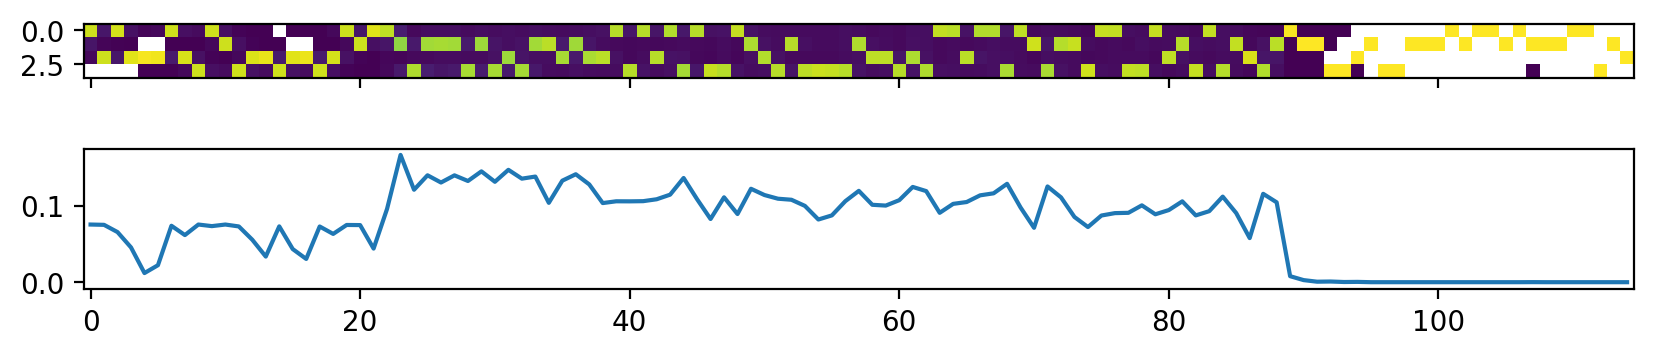

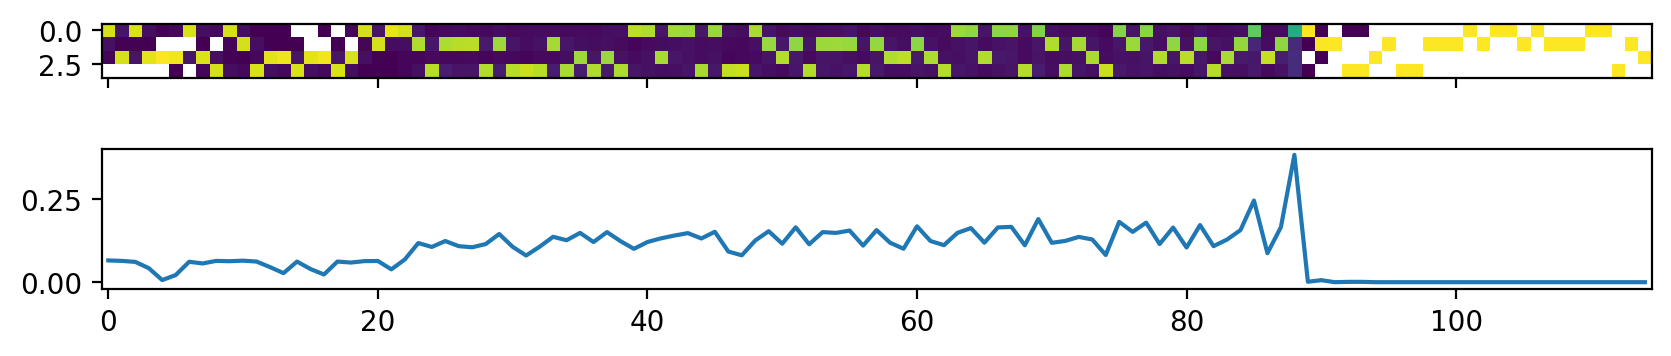

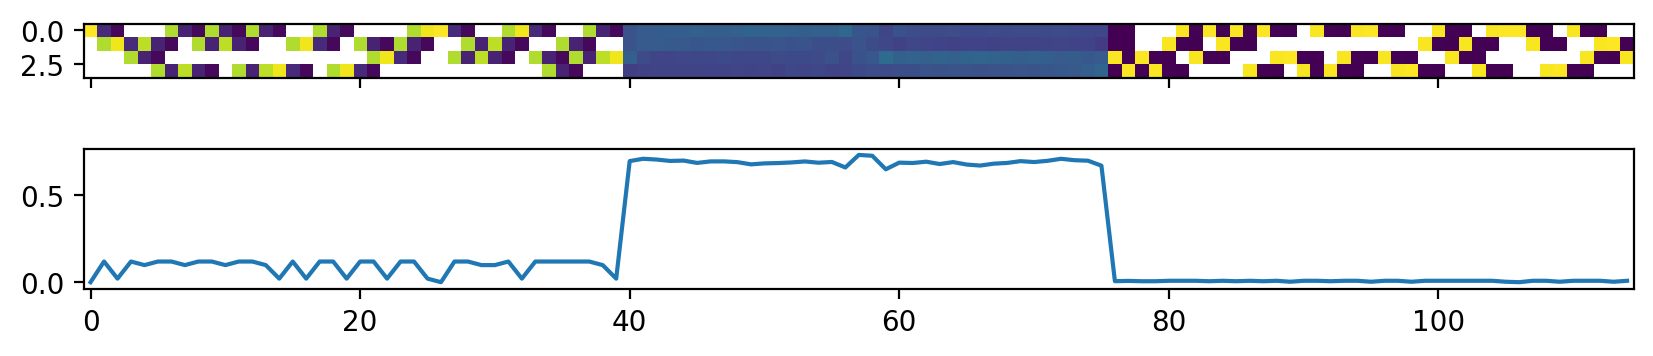

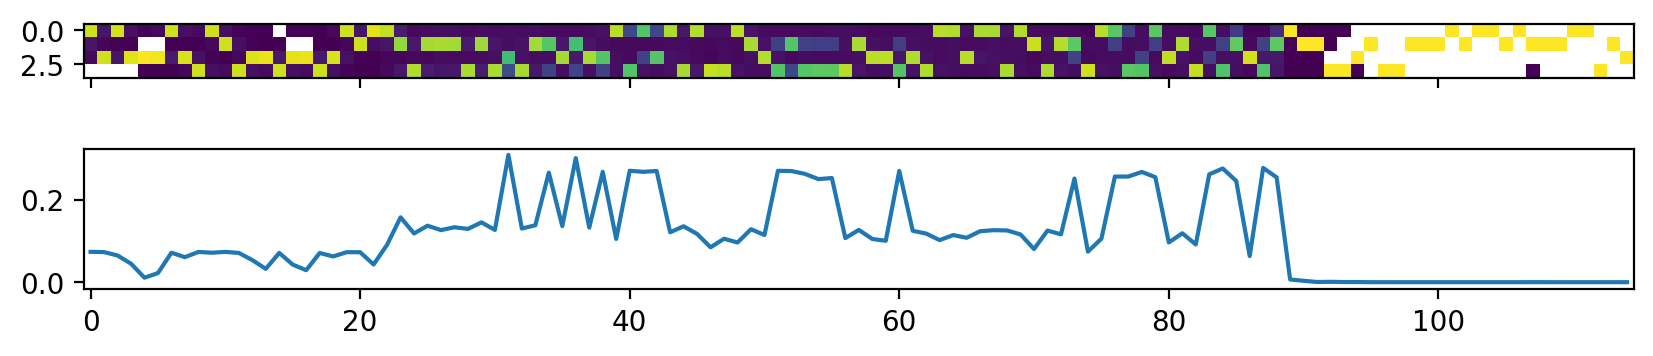

In [54]:
for dataID in DataDict:
    seqs = numData["all"][dataID]["seqs"]
    df = pd.DataFrame([pd.Series(seqs.T[i]).value_counts() for i in range(seqs.shape[1])]).T
    fig, axs = plt.subplots(2, 1, figsize=(10, 2), sharex=True)
    axs[0].imshow(df)
    axs[1].plot(range(len(df.max(axis=0))), 1-df.max(axis=0)/df.max().max())
#     break

### Import models

In [15]:
models = OrderedDict()
for fitID in ["Pr","Pr.Pl.36N"]:
    folder = f"../models/fitted_on_{fitID}/"
    for modelFile in sorted(os.listdir(folder)):
        if "model" not in modelFile: continue
        with open(folder+modelFile, "rb") as f:
            modelName = modelFile.split(".")[0].lstrip("model_")+f"[{fitID}]"
            models[modelName] = pickle.load(f)
            models[modelName]["folder"] = folder

C:\Users\drago\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
pd.DataFrame(models).T

,DataIDs,spFlex,bindMode,includeRC,Layout,ThDict,chem.pot,sp.penalties,matrices,en.scale,min.spacer,logisticRegression,folder,logClearanceRate
[0]_stm[Pr],"[Pr.Pl, 36N]",0,max,0,"[12, 8, 12]","{'Pr.Pl': 77, '36N': -1}","{'Pr.Pl': -18.84561179825073, '36N': -22.32183...",[0],"[[[0.0, 0.7040774227405244, -0.092120720116618...",1,8,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr/,NaN
[1]_stm+flex[Pr],"[Pr.Pl, 36N]",2,max,0,"[12, 8, 12]","{'Pr.Pl': 75, '36N': -1}","{'Pr.Pl': -17.610896702945773, '36N': -19.590712}","[1.8049884895346935, 1.76418583090379, 0.0, 1....","[[[0.0, 1.0370464081632649, 0.1297438367346933...",1,6,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr/,NaN
[2]_stm+flex+cumul[Pr],"[Pr.Pl, 36N]",2,add,0,"[12, 8, 12]","{'Pr.Pl': 75, '36N': -1}","{'Pr.Pl': -17.56085014317901, '36N': -19.470752}","[1.7452471475218656, 1.9335519941690962, 0.0, ...","[[[0.0, 0.9620704227405252, 0.0382514285714282...",1,6,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr/,NaN
[3]_stm+flex+cumul+rbs[Pr],"[Pr.Pl, 36N]",2,add,0,"[12, 8, 12]","{'Pr.Pl': 55, '36N': -1}","{'Pr.Pl': -18.28291645481049, '36N': -19.5282704}","[1.860088117470787, 1.9345812769679307, 0.0, 1...","[[[0.0, 1.0000781486880466, 0.0353590204081630...",1,6,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr/,NaN
[4]_stm+flex+cumul+rbs+rc[Pr],"[Pr.Pl, 36N]",2,add,1,"[12, 8, 12]","{'Pr.Pl': 55, '36N': -1}","{'Pr.Pl': -18.144299720116617, '36N': -19.8591...","[1.7954461618629036, 1.945897725947522, 0.0, 1...","[[[0.0, 0.926849294460642, -0.0196222448979583...",1,6,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr/,NaN
[0]_stm[Pr.Pl.36N],"[Pr.Pl, 36N]",0,max,0,"[12, 8, 12]","{'Pr.Pl': 0, '36N': 0}","{'Pr.Pl': -17.925556286562, '36N': -18.5105192...",[0],"[[[0.0, 1.1880678892965266, 0.6641001048482882...",1,8,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr.Pl.36N/,NaN
[1]_stm+flex[Pr.Pl.36N],"[Pr.Pl, 36N]",2,max,0,"[12, 8, 12]","{'Pr.Pl': 0, '36N': 0}","{'Pr.Pl': -18.03750400147544, '36N': -18.51051...","[9.214861139368063, 2.2524841750108124, 0.0, 1...","[[[0.0, 0.8920357190588171, 0.5089953645394663...",1,6,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr.Pl.36N/,NaN
[2]_stm+flex+cumul[Pr.Pl.36N],"[Pr.Pl, 36N]",2,add,0,"[12, 8, 12]","{'Pr.Pl': 0, '36N': 0}","{'Pr.Pl': -17.908525893586578, '36N': -18.5105...","[8.179763367905347, 2.2477285735281765, 0.0, 1...","[[[0.0, 0.6707675942519951, 0.269700587671803,...",1,6,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr.Pl.36N/,NaN
[3]_stm+flex+cumul+rbs[Pr.Pl.36N],"[Pr.Pl, 36N]",2,add,0,"[12, 8, 12]","{'Pr.Pl': 55, '36N': 0}","{'Pr.Pl': -18.976465401312268, '36N': -18.5105...","[8.580783027261091, 2.2402695963516, 0.0, 1.29...","[[[0.0, 0.7042573919200334, 0.2901087509371091...",1,6,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr.Pl.36N/,NaN
[4]_stm+flex+cumul+rbs+rc[Pr.Pl.36N],"[Pr.Pl, 36N]",2,add,1,"[12, 8, 12]","{'Pr.Pl': 55, '36N': 0}","{'Pr.Pl': -17.666871259475222, '36N': -18.5105...","[8.513618275205907, 2.1215349854227403, 0.0, 1...","[[[0.0, 0.6782265714285716, 0.2725781404418823...",1,6,{'Pr.Pl': LogisticRegression(C=100000000000000...,../models/fitted_on_Pr.Pl.36N/,NaN


### Calculate

In [17]:
def refitChemPot(model, objF):
    model = deepcopy(model)
    objChemPot = {}
    for parId in ["Pr.Pl","36N"]:
        mu0 = model["chem.pot"][parId]
        if parId=="36N":
            dataID = "36N"
        elif "Pr.Pl" in model["DataIDs"]:
            dataID = "Pr.Pl"
        else: 
            dataID = "Pr"
        mu0 = model["chem.pot"][parId]
        def toMin(x):
            try: x = x[0]
            except: pass
            model["chem.pot"][parId] = x
            r = lps2eval(model, objF, numData=numData, fit=False, tt="training", DataIDs_=[dataID])
            out = r[dataID] if objF=="mlogL" else -r[dataID]
            return out
        mus = np.arange(-40,-10,.5)
        ys = np.array([toMin(mu) for mu in mus])
        objChemPot[parId] = mus[np.argmin(ys)]
    return objChemPot

In [18]:
for objF in ["mlogL", "linR2"]:
    for refit in [False, True]:
        if objF=="mlogL" and refit: 
            continue
        Results = OrderedDict()
        for modelName in models:
            model = deepcopy(models[modelName])
            Results[modelName] = OrderedDict()
            if refit:
                model["chem.pot_%s"%objF] = refitChemPot(model, objF)
            for tt in numData:
                res = lps2eval(model, objF, numData=numData, fit=False, DataIDs_=DataDict.keys(), tt=tt)
                for dataID in DataDict: 
                    Results[modelName][dataID+"_"+tt] = res[dataID]

        Results = pd.DataFrame(Results)
        saveName = f"comparison_{objF}"
        if refit:
            saveName += "_refitted_mu"
        Results.to_csv(f"models/{saveName}.csv")

OSError: Cannot save file into a non-existent directory: 'models'

#### add pairwise interactions

If the cells are evaluated in order, the current `model` contains the `chem.pot_linR2`, so we calculate the R2 with the pairwise interactions now

In [61]:
newModelName = "[6]_extended+pwi[Pr.Pl.36N]"

In [47]:
dinuDF = pd.read_csv("pairwise_interactions.csv", index_col=0)
dinuDF["interaction"] = list(map(eval, dinuDF["interaction"]))

In [50]:
# refitted linR2
dinuRes = OrderedDict()
for tt in numData:
    res = lps2eval(
        model, objF, numData=numData, fit=False, DataIDs_=DataDict.keys(), tt=tt,
        dinucl=True,
        dinuCoordsAndValues=(dinuDF.interaction.values, dinuDF.value.values)
                  )
    for dataID in DataDict: 
        dinuRes[dataID+"_"+tt] = res[dataID]

Results[newModelName] = pd.Series(dinuRes)

Results.to_csv(f"models/{saveName}.csv")

In [63]:
# native mlogL and linR2
refit=False
model = deepcopy(models["[5]_extended[Pr.Pl.36N]"])
for objF in ["linR2","mlogL"]:
    dinuRes = OrderedDict()
    for tt in numData:
        res = lps2eval(
            model, objF, numData=numData, fit=False, DataIDs_=DataDict.keys(), tt=tt,
            dinucl=True,
            dinuCoordsAndValues=(dinuDF.interaction.values, dinuDF.value.values)
                      )
        for dataID in DataDict: 
            dinuRes[dataID+"_"+tt] = res[dataID]

    savePath = f"models/comparison_{objF}.csv"
    Results = pd.read_csv(savePath, index_col=0)
    Results[newModelName] = pd.Series(dinuRes)
    Results.to_csv(savePath)

### See

#### $-\log \mathcal{L}$

In [64]:
Results = pd.read_csv("models/comparison_mlogL.csv", index_col=0)

In [65]:
for fitID in ["Pr","Pr.Pl.36N"]:
    print ("\n","="*40,"fitted on", fitID)
    for dataID in ["Pr",'Pl',"36N"]:
        df = Results.loc[
            [i for i in Results.index if i.split("_")[0]==dataID],
            [c for c in Results.columns if f"[{fitID}]" in c]
                   ].copy()
        df = df.rename({c:c.split("_")[0] for c in df.columns}, axis="columns")
        showdf(df.diff(axis=1))


 ======================================== fitted on Pr


,[0],[1],[2],[3],[4]
Pr_training,nan,-595.6,-29.4,-23.3,-11.3
Pr_validation,nan,-192.2,-13.6,-12.1,0.4
Pr_evaluation,nan,-181.4,-15.3,-3.9,-2.4
Pr_all,nan,-967.9,-58.7,-39.8,-13.2


,[0],[1],[2],[3],[4]
Pl_training,nan,51.4,-0.2,-77.0,37.6
Pl_validation,nan,-29.9,-2.7,-4.3,0.6
Pl_evaluation,nan,-31.5,-2.5,-5.1,2.0
Pl_all,nan,-10.6,-5.7,-86.4,40.1


,[0],[1],[2],[3],[4]
36N_training,nan,-1013.8,-125.7,-8.0,-28.5
36N_validation,nan,-353.3,-33.7,-8.9,-5.3
36N_evaluation,nan,-357.8,-31.2,-7.4,-0.6
36N_all,nan,-1781.1,-188.3,-24.2,-34.4



 ======================================== fitted on Pr.Pl.36N


,[0],[1],[2],[3],[4],[5],[6]
Pr_training,nan,-715.6,-60.1,-32.7,-22.5,-3.2,-69.7
Pr_validation,nan,-222.2,-26.8,-13.3,-7.8,-0.4,-24.7
Pr_evaluation,nan,-233.5,-12.7,3.0,-4.8,-0.3,-23.6
Pr_all,nan,-1170.6,-99.8,-43.5,-35.2,-4.1,-117.8


,[0],[1],[2],[3],[4],[5],[6]
Pl_training,nan,-102.7,-5.9,-18.7,10.3,0.5,-13.5
Pl_validation,nan,-58.8,-2.5,0.4,-2.5,0.4,-4.4
Pl_evaluation,nan,-57.2,-2.9,0.5,-1.3,0.2,-5.9
Pl_all,nan,-219.5,-11.3,-17.8,6.4,1.2,-23.6


,[0],[1],[2],[3],[4],[5],[6]
36N_training,nan,-1003.2,-90.1,-8.4,-9.6,-8.1,-131.1
36N_validation,nan,-327.9,-52.5,-3.2,4.6,-3.4,-35.4
36N_evaluation,nan,-370.3,-21.4,0.2,5.5,-5.4,-32.1
36N_all,nan,-1792.1,-159.7,-9.6,3.1,-18.5,-198.4


#### `linR2`

In [66]:
Results = pd.read_csv("models/comparison_linR2_refitted_mu.csv", index_col=0)
# Results = pd.read_csv("models/comparison_mlogL.csv", index_col=0)

In [67]:
for dataID in ["Pr",'Pl',"36N"]:
    df = Results.loc[[i for i in Results.index if i.split("_")[0]==dataID]].copy()
    df = df.rename({c:c.split("_")[0]+" "+c.split("[")[-1][:-1] for c in df.columns}, axis="columns")
    showdf(df*100)

,[0] Pr,[1] Pr,[2] Pr,[3] Pr,[4] Pr,[0] Pr.Pl.36N,[1] Pr.Pl.36N,[2] Pr.Pl.36N,[3] Pr.Pl.36N,[4] Pr.Pl.36N,[5] Pr.Pl.36N,[6] Pr.Pl.36N
Pr_training,73.3,79.0,79.8,79.6,79.5,68.7,76.9,78.1,77.9,77.9,78.0,78.6
Pr_validation,72.9,79.8,80.6,80.5,80.3,69.2,77.4,78.7,78.7,78.7,78.8,79.5
Pr_evaluation,74.7,79.9,80.9,80.6,80.5,70.8,78.4,79.3,78.7,78.7,78.7,79.3
Pr_all,73.5,79.3,80.2,80.0,79.9,69.2,77.3,78.4,78.2,78.2,78.3,79.0


,[0] Pr,[1] Pr,[2] Pr,[3] Pr,[4] Pr,[0] Pr.Pl.36N,[1] Pr.Pl.36N,[2] Pr.Pl.36N,[3] Pr.Pl.36N,[4] Pr.Pl.36N,[5] Pr.Pl.36N,[6] Pr.Pl.36N
Pl_training,65.9,69.4,70.6,70.8,70.4,63.2,69.2,70.8,70.5,70.6,70.6,71.0
Pl_validation,62.9,69.4,70.4,70.3,70.1,61.5,69.3,70.8,70.4,70.6,70.7,71.4
Pl_evaluation,64.8,69.5,70.5,70.7,70.4,62.5,69.3,70.8,70.7,70.7,70.7,71.3
Pl_all,65.1,69.4,70.5,70.7,70.3,62.7,69.2,70.8,70.5,70.6,70.6,71.1


,[0] Pr,[1] Pr,[2] Pr,[3] Pr,[4] Pr,[0] Pr.Pl.36N,[1] Pr.Pl.36N,[2] Pr.Pl.36N,[3] Pr.Pl.36N,[4] Pr.Pl.36N,[5] Pr.Pl.36N,[6] Pr.Pl.36N
36N_training,34.1,53.8,55.7,55.8,56.2,46.3,64.5,65.7,65.8,66.0,66.0,68.2
36N_validation,38.1,55.6,56.9,57.4,57.6,47.5,64.7,67.1,67.1,66.9,67.1,68.8
36N_evaluation,51.0,64.8,65.5,65.8,65.7,61.7,76.8,77.8,77.7,77.5,77.6,78.9
36N_all,38.5,57.4,58.8,59.0,59.3,49.6,67.9,69.3,69.3,69.3,69.4,71.3
